# **Problem Statement**
About 40% of our transactions are cashless - meaning we are charging clients and paying majority of the charge to the driver every week (withholding our 15-25% commissions).

We always pay the driver and take the risk for collecting the funds from the client. 

Luckily, we have basic filters to block users from making multiple fraudulent transactions and find groups of fraudulent users using the same devices or cards. 


# **Goal**
Stop first timer from doing fraudulent transaction and develop a top 2-5 solotions will help reduce the percent of failed payments.

# Goals & Business Questions

* Findout the pattern in the fraudulent transaction
  * what are the type of fraud transaction?
  * What day and weekday do fraud transaction usually happened?
  * When does fraud transaction usually happened?
  * Device identification?
  * Country
  
* Findout What model of machine learning that's the best recall score to   predict a fraud transaction
  * What is the best machine learning model to predict fraud transaction

# Data Dictionaries and MetaData
* created – time when the 1st time order request was created.
* device_name – name of the device used to make order
* device_os_version – version of the device OS
* country – 2 char country code
* city_id – internal system city ID (not relevant which one is which)
* lat – latitude of the pickup spot for the order
* lng – longitude of the pickup spot for the order
* real_destination_lat – latitude of the destination for the order
*  real_destination_lng – longitude of the destination for the order
*  user_id – internal user ID
*  order_id – internal order ID
* order_try_id – internal order try ID (order tries happen before client and driver are matched to an order)
*  distance – driver distance to the client pickup location, in meters
*  ride_distance – trip distance in meters
*  price – price charged to client, can be lower than “ride_price” if client had a discount, currencies vary and are undefined
*  ride_price – calculated price of the final trip, currencies vary and are undefined
*  price_review_status – “Price review” is when we send “ride_price” to be audited by human to check for system errors. 99% of orders are final and should have “ok” already set. There might be some that are still in pending states, most likely you can discard those.
*  price_review_reason – automatic or manual reason for the price review to be requested.
*  is_successful_payment – 1 means order was charged successfully, 0 mean it has failed (including after all attempts to re-charge)
*  name – card details, irrelevant.
*  card_bin – details on card BIN.
*  failed_attempts – number of failed order attempts before this 1st finished order.


In [106]:
# import python packages 
import pandas as pd  
import numpy as np  
import sidetable as stb
import seaborn as sns
import matplotlib.pyplot as plt

In [107]:
# load dataset from file
data = pd.read_csv('1st_adyen_rides-success-and-fail.csv')

In [108]:
# a quick overview of the dataset
data.head(3)

,created,device_name,device_os_version,country,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,...,distance,ride_distance,price,ride_price,price_review_status,price_review_reason,is_successful_payment,name,card_bin,failed_attempts
0,2016-01-23 23:10:07,motorolaXT1562,motorola6.0.1,ee,2.0,58.378220,26.710402,58.363243,26.737696,218,...,773,3017,4.5,4.5,ok,NaN,1,**** 0810,NaN,0
1,2016-05-04 06:01:32,iPhone6,iOS10.3.3,ee,1.0,59.424130,24.646359,59.397548,24.660957,266,...,43,4241,4.4,4.4,ok,NaN,1,**** 9115,NaN,0
2,2016-08-27 16:42:22,HTCHTC 10,HTC7.0,ee,1.0,59.413508,24.743706,59.448500,24.804887,551,...,1654,6347,7.2,7.2,ok,NaN,1,**** 0634,516903.0,0


In [109]:
# number of rows and colnums in the dataset
data.shape

(304053, 22)

In [110]:
# names of columns 
data.columns

Index(['created', 'device_name', 'device_os_version', 'country', 'city_id',
       'lat', 'lng', 'real_destination_lat', 'real_destination_lng', 'user_id',
       'order_id', 'order_try_id', 'distance', 'ride_distance', 'price',
       'ride_price', 'price_review_status', 'price_review_reason',
       'is_successful_payment', 'name', 'card_bin', 'failed_attempts'],
      dtype='object')

In [111]:
# the type of the columns can be found out as follows and we have some missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304053 entries, 0 to 304052
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   created                304053 non-null  object 
 1   device_name            304053 non-null  object 
 2   device_os_version      304053 non-null  object 
 3   country                304052 non-null  object 
 4   city_id                303734 non-null  float64
 5   lat                    304053 non-null  float64
 6   lng                    304053 non-null  float64
 7   real_destination_lat   304026 non-null  float64
 8   real_destination_lng   304026 non-null  float64
 9   user_id                304053 non-null  int64  
 10  order_id               304053 non-null  int64  
 11  order_try_id           304053 non-null  int64  
 12  distance               304053 non-null  int64  
 13  ride_distance          304053 non-null  int64  
 14  price                  304053 non-nu

In [112]:
# convert created from string to datetime then create dates and hour features
data.created = pd.to_datetime(data['created'])
data['hour'] = data['created'].dt.hour
data['day'] = data['created'].dt.day
data['month'] = data['created'].dt.month
data['weekday'] = data['created'].dt.weekday

In [113]:
# there are 79033 failed payments which were fraudulent and 225020 seccussful payment which were legitimate in our data.
data['is_successful_payment'].value_counts()

1    225020
0     79033
Name: is_successful_payment, dtype: int64

In [114]:
# let us get a sense of the numbers across these two classes:

data.groupby('is_successful_payment').mean()

# The average sum of distance and failed attempts which were fraudulent payment are bigger than that of those 
# of the valid transactions.

,city_id,lat,lng,real_destination_lat,real_destination_lng,user_id,order_id,order_try_id,distance,ride_distance,price,ride_price,card_bin,failed_attempts,hour,day,month,weekday
is_successful_payment,,,,,,,,,,,,,,,,,,
0,133.781737,25.568931,18.704488,25.569995,18.704380,1.131575e+06,1.318709e+07,1.354593e+07,1660.214353,9317.228525,84.117434,132.184240,490884.903226,0.525502,13.826769,15.794251,6.493136,3.348753
1,70.676221,31.809105,24.468779,31.810082,24.470396,1.036689e+06,1.413214e+07,1.450879e+07,1613.986206,9462.326531,316.900482,330.191812,495035.773431,0.318798,13.141854,15.575882,6.065830,3.285397


In [115]:
# print the ratio of payments
ratio_payment = round(data['is_successful_payment'].value_counts()/len(data.index) *100, 2)
print(f'Ratio of successful payment: {ratio_payment[1]}%\nRatio of failed payment: {ratio_payment[0]}%')

# there seems to approximately 26% of the failed paymanets and that's one-fourth of the entire paymenet.

Ratio of successful payment: 74.01%
Ratio of failed payment: 25.99%


In [116]:
# get the average ride price per country for failed payment
failed_payments = pd.pivot_table(data, index=['country', 'price_review_reason', 'is_successful_payment', 'ride_distance'], aggfunc={'ride_price' : 'mean'}).sort_values(by=('ride_price'), ascending=False).round(2)
failed_payments = failed_payments.reset_index()

# split the dataframe into seven smaller dataframes based on branch
failed_ = failed_payments.loc[failed_payments['is_successful_payment'] == 0]
failed_

,country,price_review_reason,is_successful_payment,ride_distance,ride_price
0,hu,price_too_high,0,221703,64210.0
1,hu,price_too_high,0,174775,49770.0
4,rs,price_too_high,0,54451,28500.0
5,ng,price_too_high,0,300944,28100.0
8,ng,price_too_high,0,192625,17100.0
...,...,...,...,...,...
1101,ng,price_too_high,0,229195,0.0
1102,ng,price_too_high,0,275958,0.0
1103,ke,price_too_high,0,355492,0.0
1104,ke,price_too_high,0,301941,0.0


In [47]:
data[['country', 'ride_distance', 'ride_price', 'is_successful_payment']].groupby('country')\
  .agg(['mean','count'])\
    .sort_values(by=('ride_price','mean'), ascending=False).round(2)

# the majority of fraud is observed are in country like NG, RS, UA, MX, GH, and SA.

ride_distance        ride_price        is_successful_payment       
                 mean  count       mean  count                  mean  count
country                                                                    
ca           10010.00      1    6100.00      1                  0.00      1
hu            7746.58  23137    2857.73  23137                  0.96  23137
ng           28443.22    483    2734.04    483                  0.13    483
ke           16694.82   3427     737.16   3427                  0.70   3427
rs            6941.17   3006     706.52   3006                  0.33   3006
cz            9725.34   9648     178.63   9648                  0.60   9648
ua           11975.33   7652     108.43   7652                  0.45   7652
za           12338.69  78694     103.37  78694                  0.71  78694
mx           17408.58   6798      96.63   6798                  0.36   6798
gh           24318.66     56      35.38     56                  0.18     56
eg           20554.17    501      30.55    501                  0.69    501
pl            9607.93   6037      19.14   6037                  0.50   6037
fi            8246.28    397      18.31    397                  0.84    397
ro            7775.64  18127      17.28  18127                  0.64  18127
mt            7299.56   1045      12.04   1045                  0.98   1045
sa              24.00      1       8.00      1                  0.00      1
ee            6808.86  43780       6.33  43780                  0.91  43780
ge            7127.28  12795       6.11  12795                  0.91  12795
lv            8008.98  55707       5.72  55707                  0.77  55707
lt            6983.74  20862       5.31  20862                  0.71  20862
sk            7535.42   4888       4.96   4888                  0.54   4888
az           11441.74   7010       4.50   7010                  0.60   7010

In [48]:
data[['device_name', 'ride_price', 'is_successful_payment']].groupby('device_name')\
  .agg(['mean','count'])\
    .sort_values(by=('ride_price','mean'), ascending=False).round(2)

# the majority of fraud is observed are in country like NG, RS, UA, MX, GH, and SA.

ride_price       is_successful_payment      
                       mean count                  mean count
device_name                                                  
TECNOTECNO 7C      13950.00     1                  0.00     1
GiONEEP5 mini      10195.00     8                  0.00     8
azumiA40C           9622.00     1                  0.00     1
HTCHTC One XL       9571.67     3                  0.33     3
iPad5               8910.00     1                  1.00     1
...                     ...   ...                   ...   ...
SageRealTECNO H5       0.00     1                  0.00     1
samsungGT-S6790N       0.00     1                  0.00     1
samsungSM-T715C        0.00     1                  0.00     1
LGELG-F460S            0.00     1                  0.00     1
alpsRover              0.00     1                  0.00     1

[4043 rows x 4 columns]

# Sampling the Data

In [49]:
15720 / len(data.index)

# From the sample size calculator we only need to use 0.05170(0.052) after rounding out of total dataframe

0.05170151256524356

In [50]:
# using this sample size calculator https://www.qualtrics.com/blog/calculating-sample-size/
# with confidence level of 99%
# population size of 304053
# and margin of error of 1 % 
# the ideal sample size for this population is 15720

# for this i will be using 10 % of the data as a sample 

sample = data.groupby('is_successful_payment').apply(lambda x: x.sample(frac=0.052))

In [51]:
#round(len(sample[sample['is_successful_payment'] == 0]) / len(sample.index) *100, 2)
print(f'Ratio of successful payment: {round(len(sample[sample["is_successful_payment"] == 1]) / len(sample.index) *100, 2)}%\nRatio of failed payment: {round(len(sample[sample["is_successful_payment"] == 0]) / len(sample.index) *100, 2)}%')

# total failed payments in the original and smaple dataset are the same and pretty high 

Ratio of successful payment: 74.01%
Ratio of failed payment: 25.99%


In [52]:
## taking a look at our target variable 
## fraud transaction here

sample[sample['is_successful_payment'] == 0]

# we can already see a pattern for the sample dataset that is fraud
# most of the devices used are iPhone and number of failed attemps is zero meaning payment was never initiated

# * note sample

created       device_name  \
is_successful_payment                                                
0                     211876 2017-07-27 19:27:13   samsungSM-G950F   
                      216321 2017-01-16 06:49:59           iPhone5   
                      110379 2017-05-19 20:24:59  samsungGT-I9060I   
                      241789 2017-07-28 13:12:09   samsungGT-I9190   
                      95926  2017-02-13 15:32:51         iPhone6,1   
...                                          ...               ...   
                      219424 2017-06-17 00:35:20           iPhone6   
                      132876 2017-05-16 13:58:05    HuaweiMLA-TL10   
                      23876  2016-11-20 19:57:44       LGENexus 5X   
                      48215  2016-08-06 22:47:56   samsungSM-G903F   
                      41539  2016-09-01 21:34:27         iPhone6,2   

                             device_os_version country  city_id        lat  \
is_successful_payment                                                        
0                     211876        samsung7.0      lv      3.0  56.952519   
                      216321         iOS10.3.1      za     54.0 -26.183951   
                      110379      samsung4.4.4      lv    278.0  55.866622   
                      241789      samsung4.2.2      za     54.0 -26.101389   
                      95926          iOS10.0.1      mx    317.0  19.346395   
...                                        ...     ...      ...        ...   
                      219424         iOS10.3.1      lt      9.0  54.688704   
                      132876       Huawei4.2.2      ua    158.0  50.441237   
                      23876             LGE6.0      lt      9.0  54.713684   
                      48215       samsung5.1.1      lv      3.0  56.947996   
                      41539           iOS9.3.4      cz    271.0  50.028928   

                                    lng  real_destination_lat  \
is_successful_payment                                           
0                     211876  24.063406             56.948020   
                      216321  28.025171            -26.200140   
                      110379  26.523251             55.866559   
                      241789  28.054140            -26.129511   
                      95926  -99.146314             19.397257   
...                                 ...                   ...   
                      219424  25.279907             54.717326   
                      132876  30.516226             50.438217   
                      23876   25.271920             54.704470   
                      48215   24.016849             56.960794   
                      41539   14.389409             50.099555   

                              real_destination_lng  user_id  ...  \
is_successful_payment                                        ...   
0                     211876             24.107085  2190839  ...   
                      216321             28.039652  1056736  ...   
                      110379             26.523304  1721233  ...   
                      241789             28.069749  2068113  ...   
                      95926             -99.257650  1171804  ...   
...                                            ...      ...  ...   
                      219424             25.284678  1902506  ...   
                      132876             30.475835  1673180  ...   
                      23876              25.185523   587462  ...   
                      48215              24.132165   673483  ...   
                      41539              14.401838   619503  ...   

                              price_review_status  price_review_reason  \
is_successful_payment                                                    
0                     211876           ok                          NaN   
                      216321           ok                          NaN   
                      110379           ok                          NaN   
              

# Data Visualization

Text(0.5, 1.0, 'Distribution of Payments, (1 = Successful)')

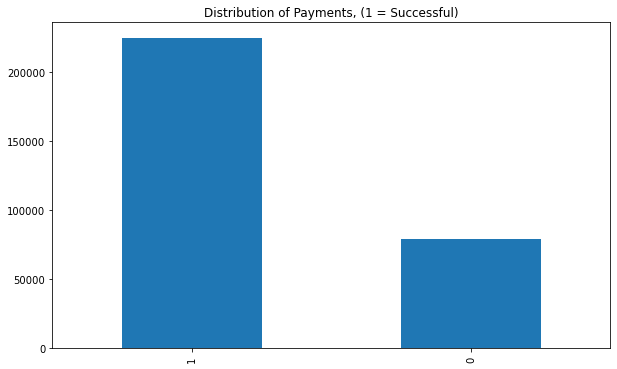

In [53]:
# bar plot of successful/failed payments 
data.is_successful_payment.value_counts().plot(kind='bar')
plt.title('Distribution of Payments, (1 = Successful)')

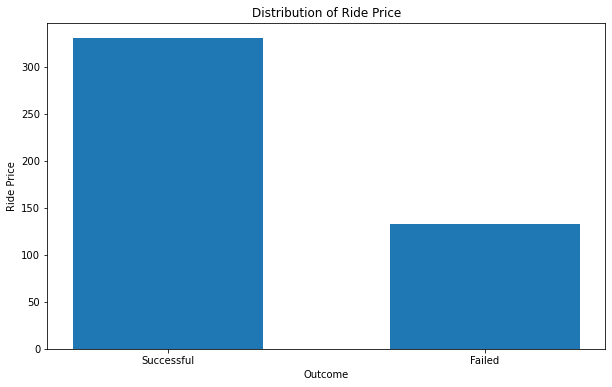

In [54]:
successful = data[data['is_successful_payment'] == 1]['ride_price'].mean()
failed = data[data['is_successful_payment'] == 0]['ride_price'].mean()
xs  = [successful, failed]
ys = ['Successful','Failed']
plt.bar(ys, xs, 0.6, align='center')
plt.xlabel('Outcome')
plt.ylabel('Ride Price')
plt.title('Distribution of Ride Price')
plt.show()

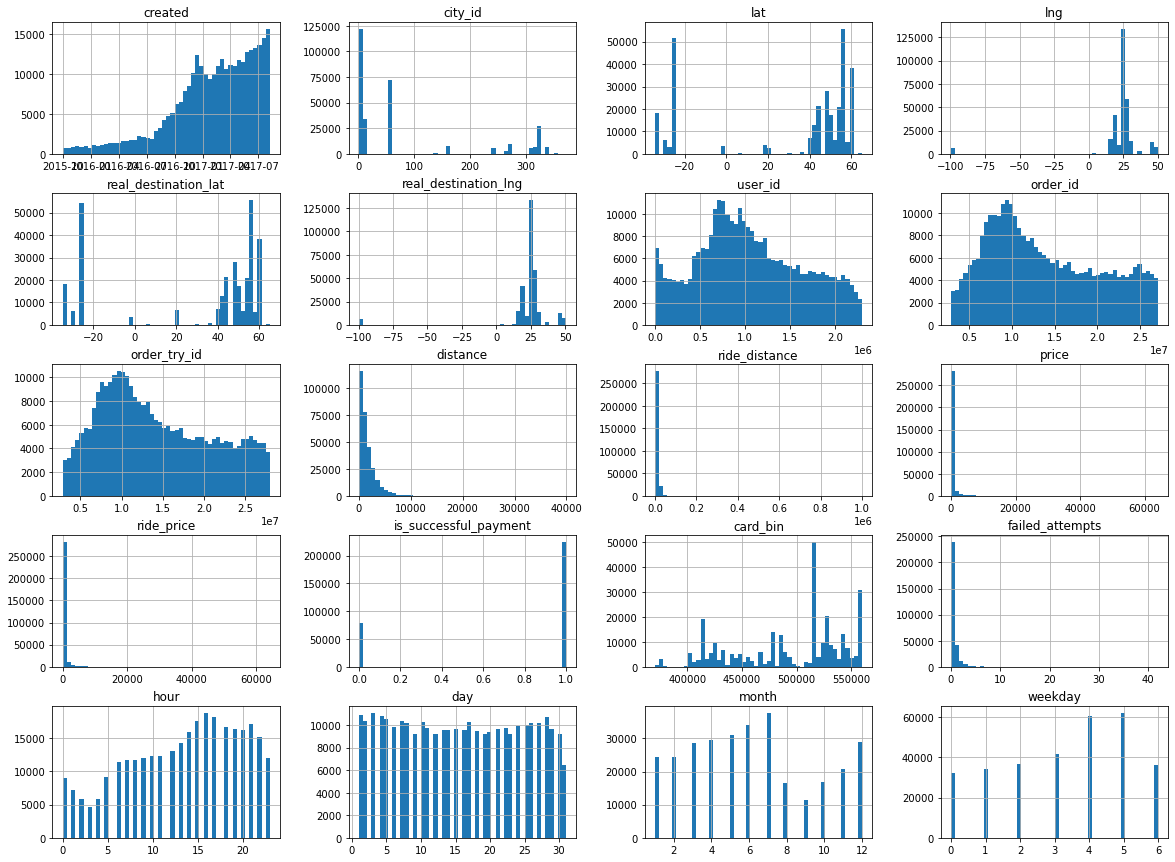

In [55]:
# histogram of numeric variables
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

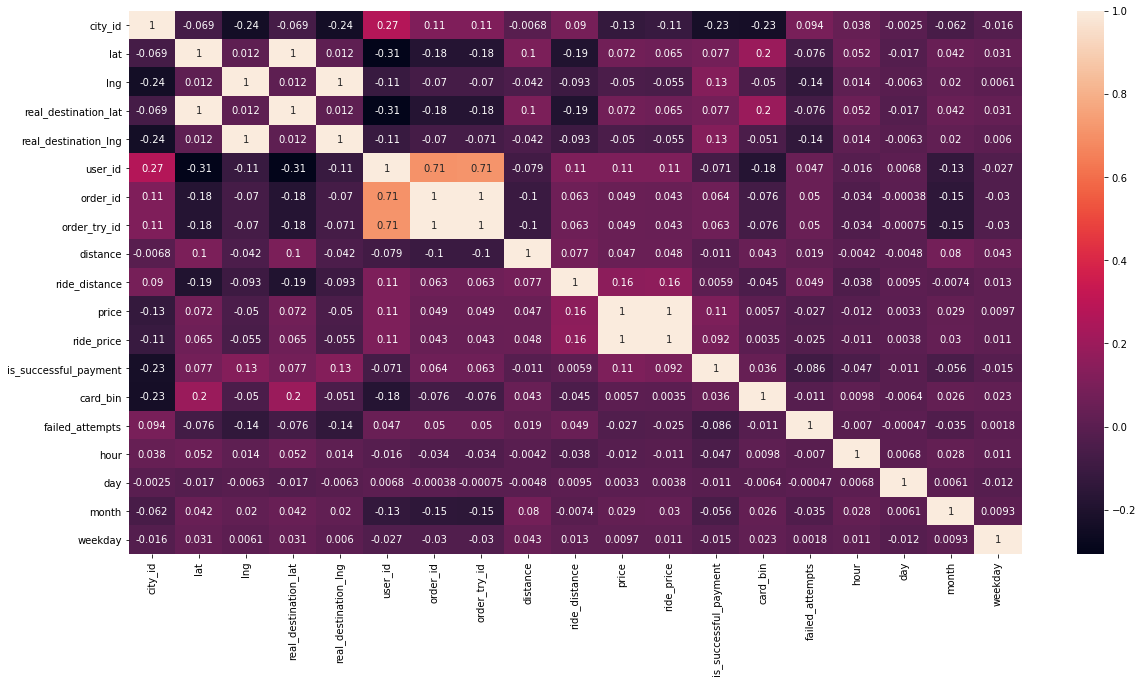

In [56]:
# the variable we are going to predict is the “fraud”. 
# so let’s look at how much each independent variable correlates with this dependent variable.

plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.heatmap(data.corr(), annot=True);

# small negative correlations between the features "city_id" and "is_successful_payment"

In [57]:
corr_matrix = data.corr()
corr_matrix['is_successful_payment'].sort_values(ascending=False)

# the feature “is_successful_payment” tends to increase when the features “real_destination_lng”, “lng”, and “price” go up. 
# The feature “is_successful_payment” tends to decrease when the features “distance”, “user_id ”, “failed_attempts”, and “city_id” go down

is_successful_payment    1.000000
real_destination_lng     0.128429
lng                      0.128388
price                    0.109027
ride_price               0.092169
lat                      0.076552
real_destination_lat     0.076551
order_id                 0.063576
order_try_id             0.063269
card_bin                 0.035967
ride_distance            0.005902
day                     -0.010686
distance                -0.011093
weekday                 -0.014805
hour                    -0.047347
month                   -0.055811
user_id                 -0.071490
failed_attempts         -0.085659
city_id                 -0.229731
Name: is_successful_payment, dtype: float64

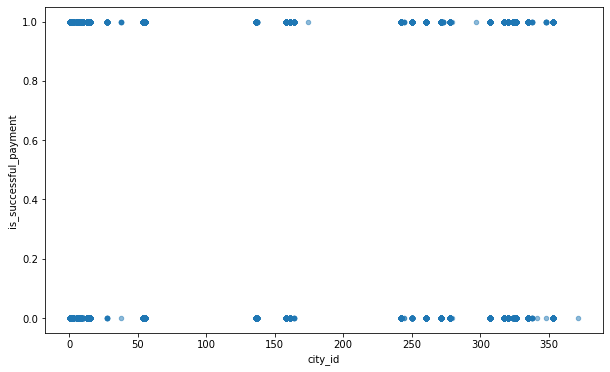

In [58]:
plt.rcParams['figure.figsize'] = (10.0, 6.0)
data.plot(kind="scatter", x='city_id', y='is_successful_payment', alpha=0.5)
plt.savefig('scatter.png')

# the correlation is indeed very weak; you can clearly see that the points are too dispersed.

In [59]:
successful = data[data['is_successful_payment'] == 1]
failed = data[data['is_successful_payment'] == 0]

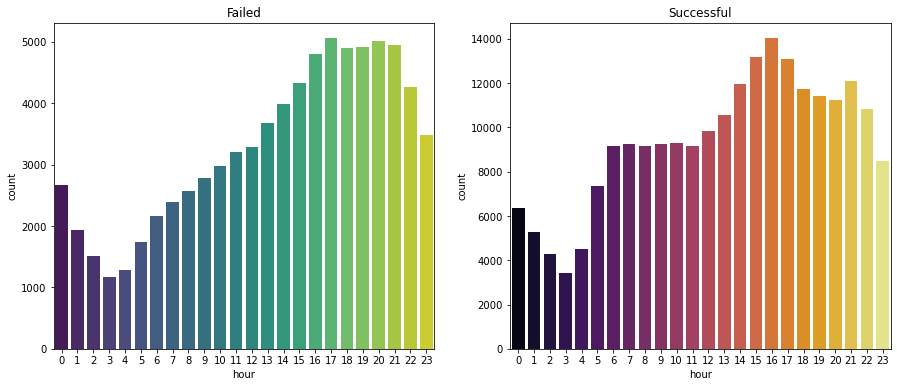

In [60]:
plt.figure(figsize = (15, 6))
plt.subplot(1,2,1)
sns.countplot(failed['hour'], palette = 'viridis')
plt.title('Failed')
plt.subplot(1,2,2)
sns.countplot(successful['hour'], palette = 'inferno')
plt.title('Successful');

# compare to the successful transactions, most of the fraudlent transactions happened between 1pm and 11pm

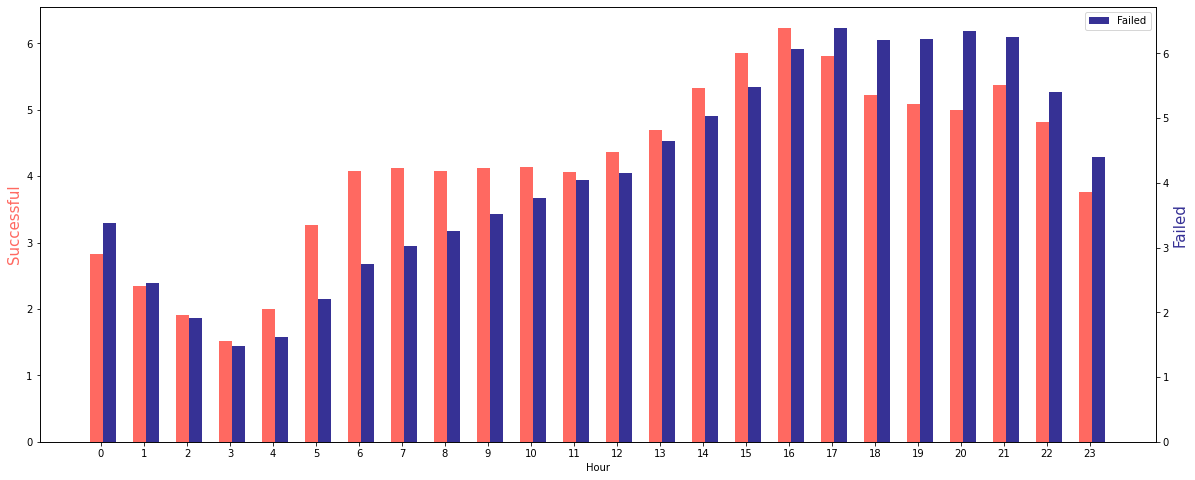

In [61]:
successful_side_table = successful.stb.freq(['hour'], cum_cols=False)
failed_side_table = failed.stb.freq(['hour'], cum_cols=False)

fig, ax1 = plt.subplots(figsize = (20,8))
ax2 = ax1.twinx()

ax1.bar(successful_side_table['hour'] - 0.3, successful_side_table['percent'], color = '#ff6961',width = 0.3)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Successful', color = '#ff6961', size = 15)
ax2.bar(failed_side_table['hour'] , failed_side_table['percent'], width = 0.3, color = '#363195')

ax2.set_ylabel('Failed', size = 15, color = '#363195')
ax1.set_xticks(np.arange(24) - 0.2)
ax1.set_xticklabels(np.arange(0,25))
plt.legend(['Failed'])

plt.show()

# from our analysis before it shows that the fraud transaction are usually constant during any time of the day 
# the percentage of fraud transaction is somewhere from 3 - 6 % in any time of the day 
# the  highest percentage of fraud transaction happened at 5 pm 



In [62]:
# Median Transaction amount per hour
failed_step_median = failed.groupby('hour').median()

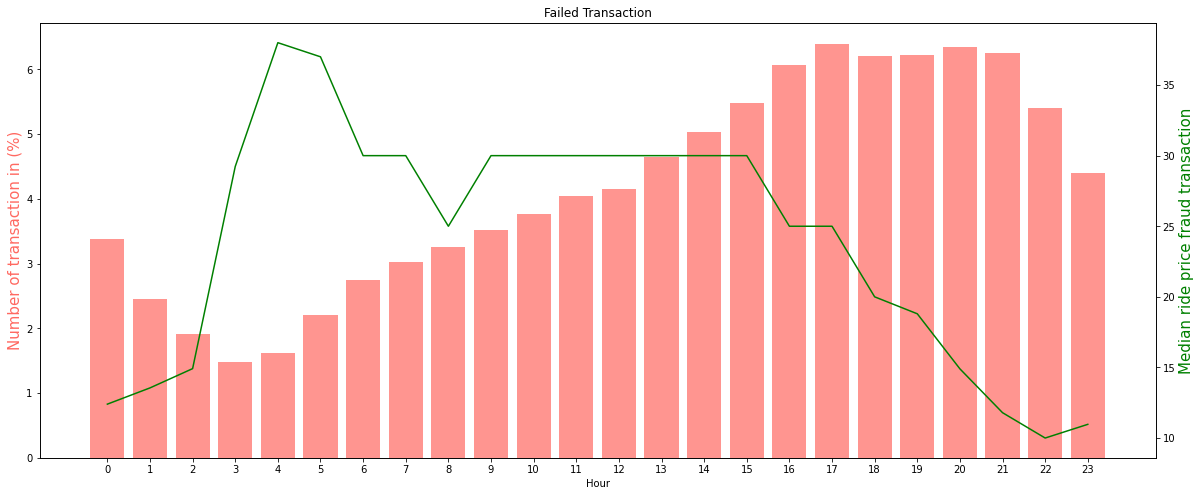

In [63]:
fig, ax1 = plt.subplots(figsize = (20,8))
ax2 = ax1.twinx()


ax1.bar(failed_side_table['hour'], failed_side_table['percent'], color = '#ff6961', alpha = 0.7)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Number of transaction in (%)', color = '#ff6961', size = 15)
ax2.plot(failed_step_median.index , failed_step_median['ride_price'], color = '#008000')

ax2.set_ylabel('Median ride price fraud transaction', size = 15, color = '#008000')
ax1.set_xticks(np.arange(24))
ax1.set_xticklabels(np.arange(0,25))

plt.title('Failed Transaction')


plt.show()

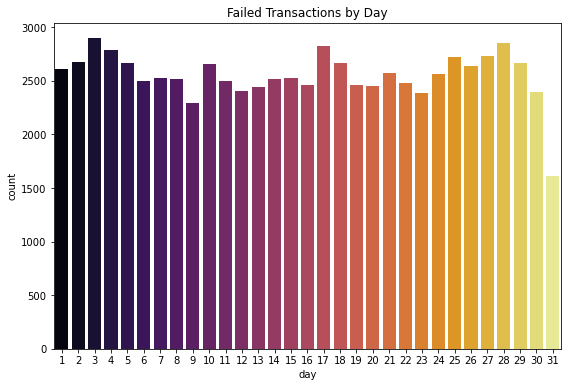

In [64]:
plt.figure(figsize = (20, 6))
plt.subplot(1,2,1)
sns.countplot(failed['day'], palette = 'inferno')
plt.title('Failed Transactions by Day');

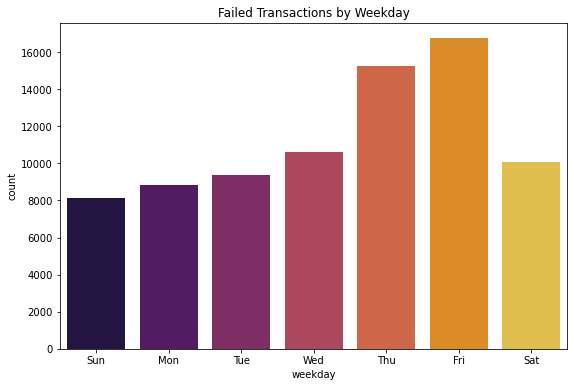

In [65]:
plt.figure(figsize = (20, 6))
plt.subplot(1,2,1)
sns.countplot(failed['weekday'], palette = 'inferno')
plt.xticks(range(7), 'Sun Mon Tue Wed Thu Fri Sat'.split())
plt.title('Failed Transactions by Weekday');

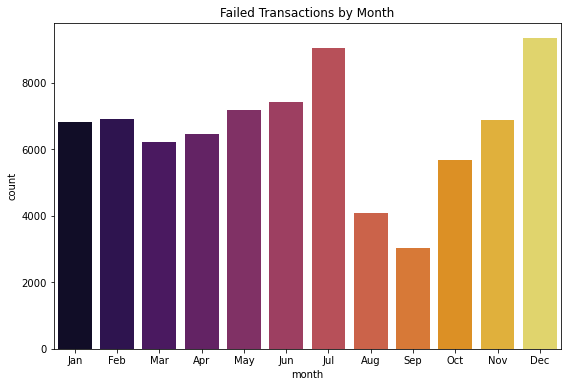

In [66]:
plt.figure(figsize = (20, 6))
plt.subplot(1,2,1)
sns.countplot(failed['month'], palette = 'inferno')
plt.xticks(range(12), 'Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec'.split())
plt.title('Failed Transactions by Month');

# EDA Findings & Recommendation

### Conclusion

* From the dataset provided, there are a total 79, 033 failed payments which consist of about 26% of the 304, 053 payments recorded and it's quite a large percentage which should call for concerns.


* Overall, the majority of the failed payments happened in the following countries such as NG, RS, UA, MX, GH, and SA and they are due mainly to high ride prices and ride distance. Further looking at the price review reason, it is observed that most of these failed payments are a result of prices being too high and there are also cases where the ride prices are zero.


* Also, the highest volumes of the failed transactions account for about 7.6% of the 79,033 failed payments that occurred between hours 1 pm and 11 pm. The findings did show that our analysis before shows that the fraud transactions are usually constant during any time of the day which is very frequent on Thursdays and Fridays, a majority in the month of July and December.


### Recommendation
* A cheaper alternative should be provided in cities/countries where fraudulent/failed transactions are frequent, and engage more drivers in locations where rides are not readily available as this will drastically reduce the frequency of failed payments and high ride prices.


* Providing discounts for first riders and discounted pricing during busy hours, especially for longer ride distance to high reduce the ride prices and in turn encourage riders to make valid payments.

# Data Preparation

In [67]:
data.isnull().sum()

created                       0
device_name                   0
device_os_version             0
country                       1
city_id                     319
lat                           0
lng                           0
real_destination_lat         27
real_destination_lng         27
user_id                       0
order_id                      0
order_try_id                  0
distance                      0
ride_distance                 0
price                         0
ride_price                    0
price_review_status           0
price_review_reason      302945
is_successful_payment         0
name                          0
card_bin                   6578
failed_attempts               0
hour                          0
day                           0
month                         0
weekday                       0
dtype: int64

In [68]:
# drop columns with larger missing values
data = data.drop(['name','device_name', 'device_os_version', 'card_bin', 'price_review_status', 'city_id', 'created', 'price_review_reason'], axis=1)
data.head(2)

,country,lat,lng,real_destination_lat,real_destination_lng,user_id,order_id,order_try_id,distance,ride_distance,price,ride_price,is_successful_payment,failed_attempts,hour,day,month,weekday
0,ee,58.37822,26.710402,58.363243,26.737696,218,4047728,4054895,773,3017,4.5,4.5,1,0,23,23,1,5
1,ee,59.42413,24.646359,59.397548,24.660957,266,5093642,5129745,43,4241,4.4,4.4,1,0,6,4,5,2


In [69]:
# Replace missing values using mode and median for categorical and numerical features respectively
data['country'] = data['country'].fillna(data['country'].mode()[0]) 
data['real_destination_lat'] = data['real_destination_lat'].fillna(data['real_destination_lat'].mean())
data['real_destination_lng'] = data['real_destination_lng'].fillna(data['real_destination_lng'].mean())

In [70]:
data.isnull().sum()

country                  0
lat                      0
lng                      0
real_destination_lat     0
real_destination_lng     0
user_id                  0
order_id                 0
order_try_id             0
distance                 0
ride_distance            0
price                    0
ride_price               0
is_successful_payment    0
failed_attempts          0
hour                     0
day                      0
month                    0
weekday                  0
dtype: int64

In [71]:
# get dummny data
df = pd.get_dummies(data)
df.head(3)

,lat,lng,real_destination_lat,real_destination_lng,user_id,order_id,order_try_id,distance,ride_distance,price,...,country_mt,country_mx,country_ng,country_pl,country_ro,country_rs,country_sa,country_sk,country_ua,country_za
0,58.378220,26.710402,58.363243,26.737696,218,4047728,4054895,773,3017,4.5,...,0,0,0,0,0,0,0,0,0,0
1,59.424130,24.646359,59.397548,24.660957,266,5093642,5129745,43,4241,4.4,...,0,0,0,0,0,0,0,0,0,0
2,59.413508,24.743706,59.448500,24.804887,551,6655300,6792534,1654,6347,7.2,...,0,0,0,0,0,0,0,0,0,0


In [72]:
df.columns

Index(['lat', 'lng', 'real_destination_lat', 'real_destination_lng', 'user_id',
       'order_id', 'order_try_id', 'distance', 'ride_distance', 'price',
       'ride_price', 'is_successful_payment', 'failed_attempts', 'hour', 'day',
       'month', 'weekday', 'country_az', 'country_ca', 'country_cz',
       'country_ee', 'country_eg', 'country_fi', 'country_ge', 'country_gh',
       'country_hu', 'country_ke', 'country_lt', 'country_lv', 'country_mt',
       'country_mx', 'country_ng', 'country_pl', 'country_ro', 'country_rs',
       'country_sa', 'country_sk', 'country_ua', 'country_za'],
      dtype='object')

# Feature Selection



In [73]:
y=df['is_successful_payment']

In [74]:
X_v=df.drop('is_successful_payment', axis=1)

In [75]:
X_v = X_v.drop(['lat', 'lng', 'real_destination_lat', 'real_destination_lng', 'order_try_id', 'ride_price'], axis=1)

In [76]:
# Detecting Multicollinearity with VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_v.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_v.values, i)
                          for i in range(len(X_v.columns))]
  
print(vif_data)

            feature       VIF
0           user_id  2.721414
1          order_id  2.264174
2          distance  1.061714
3     ride_distance  1.185196
4             price  3.008486
5   failed_attempts  1.049300
6              hour  1.018148
7               day  1.001897
8             month  1.041497
9           weekday  1.006579
10       country_az  1.669020
11       country_ca  1.000574
12       country_cz  1.732277
13       country_ee  3.914786
14       country_eg  1.046096
15       country_fi  1.027116
16       country_ge  1.864143
17       country_gh  1.006759
18       country_hu  4.990857
19       country_ke  1.343976
20       country_lt  2.540618
21       country_lv  5.042066
22       country_mt  1.113076
23       country_mx  1.701789
24       country_ng  1.074466
25       country_pl  1.457854
26       country_ro  2.473965
27       country_rs  1.173142
28       country_sa  1.000130
29       country_sk  1.400341
30       country_ua  1.658399
31       country_za  7.402115


In [77]:
from sklearn.model_selection import train_test_split

X=X_v
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42, stratify = y)

# Modeling

In [78]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [79]:
from sklearn.metrics import accuracy_score
print('Logistic regression accuracy: {:.3f}'.format(accuracy_score(y_test, logreg.predict(X_test))))

Logistic regression accuracy: 0.741


In [80]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
modelCV = LogisticRegression(max_iter=1000, random_state=42)
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print('10-fold cross validation average accuracy of the logistic regression model: %.3f' % (results.mean()))

10-fold cross validation average accuracy of the logistic regression model: 0.741


In [81]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [82]:
print('Random Forest Accuracy: {:.3f}'.format(accuracy_score(y_test, rf.predict(X_test))))

Random Forest Accuracy: 0.949


In [83]:
# cross validation attempts to avoid overfitting while still producing a prediction for each observation dataset. 
# using 10-fold Cross-Validation to train our Random Forest model.

kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
modelCV =RandomForestClassifier(random_state=42)
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print('10-fold cross validation average accuracy of the random forest model: %.3f' % (results.mean()))

10-fold cross validation average accuracy of the random forest model: 0.950


In [84]:
# XGB Classifier
import xgboost as xgb

xgb_cl = xgb.XGBClassifier(scale_pos_weight=1)
xgb_cl.fit(X_train, y_train)

c:\users\jacob\appdata\local\programs\python\python38\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
c:\users\jacob\appdata\local\programs\python\python38\lib\site-packages\xgboost\data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [85]:
print('XGBoost classifier: {:.3f}'.format(accuracy_score(y_test, xgb_cl.predict(X_test))))

XGBoost classifier: 0.950


In [86]:
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
modelCV = xgb.XGBClassifier(random_state=42)
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print('10-fold cross validation average accuracy of the XGBoost classifier model: %.3f' % (results.mean()))

10-fold cross validation average accuracy of the XGBoost classifier model: 0.950


# Evaluation

c:\users\jacob\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[1, 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


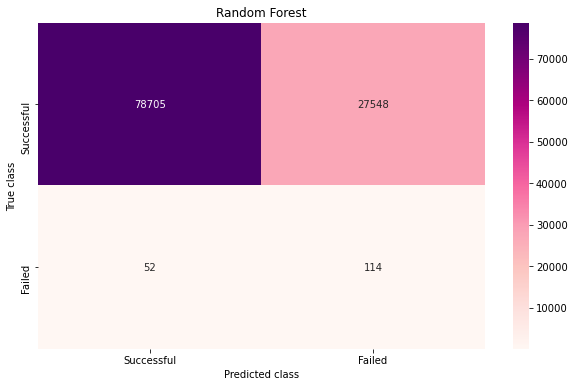

In [87]:
#Logistic Regression
from sklearn.metrics import confusion_matrix

logreg_y_pred = logreg.predict(X_test)

logreg_cm = metrics.confusion_matrix(logreg_y_pred, y_test, [1,0])
sns.heatmap(logreg_cm, cmap='RdPu', annot=True, fmt='.0f', xticklabels = ['Successful', 'Failed'], yticklabels = ['Successful', 'Failed'])
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('random_forest')

In [88]:
print('\033[1m The result is telling us that we have: ',(logreg_cm[0,0]+logreg_cm[1,1]),'correct predictions\033[1m')
print('\033[1m The result is telling us that we have: ',(logreg_cm[0,1]+logreg_cm[1,0]),'incorrect predictions\033[1m')
print('\033[1m We have a total predictions of: ',(logreg_cm.sum()))

 The result is telling us that we have:  78819 correct predictions
 The result is telling us that we have:  27600 incorrect predictions
 We have a total predictions of:  106419


In [89]:
from sklearn.metrics import classification_report
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.69      0.00      0.01     27662
           1       0.74      1.00      0.85     78757

    accuracy                           0.74    106419
   macro avg       0.71      0.50      0.43    106419
weighted avg       0.73      0.74      0.63    106419



c:\users\jacob\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[1, 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


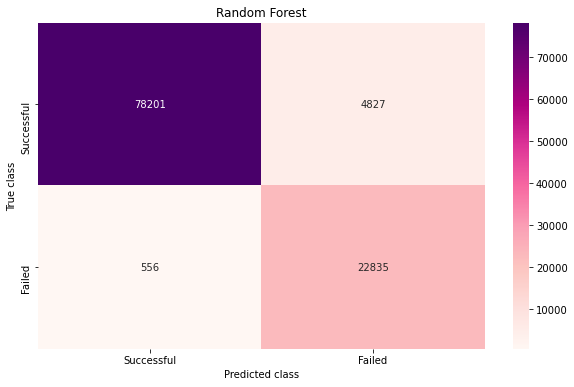

In [90]:
#Random Forest
rf_y_pred = rf.predict(X_test)

forest_cm = metrics.confusion_matrix(rf_y_pred, y_test, [1,0])
sns.heatmap(forest_cm, cmap='RdPu', annot=True, fmt='.0f', xticklabels = ['Successful', 'Failed'], yticklabels = ['Successful', 'Failed'])
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('Random Forest')
plt.savefig('random_forest')

In [91]:
print('\033[1m The result is telling us that we have: ',(forest_cm[0,0]+forest_cm[1,1]),'correct predictions\033[1m')
print('\033[1m The result is telling us that we have: ',(forest_cm[0,1]+forest_cm[1,0]),'incorrect predictions\033[1m')
print('\033[1m We have a total predictions of: ',(forest_cm.sum()))

 The result is telling us that we have:  101036 correct predictions
 The result is telling us that we have:  5383 incorrect predictions
 We have a total predictions of:  106419


In [92]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.83      0.89     27662
           1       0.94      0.99      0.97     78757

    accuracy                           0.95    106419
   macro avg       0.96      0.91      0.93    106419
weighted avg       0.95      0.95      0.95    106419



c:\users\jacob\appdata\local\programs\python\python38\lib\site-packages\xgboost\data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
c:\users\jacob\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[1, 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


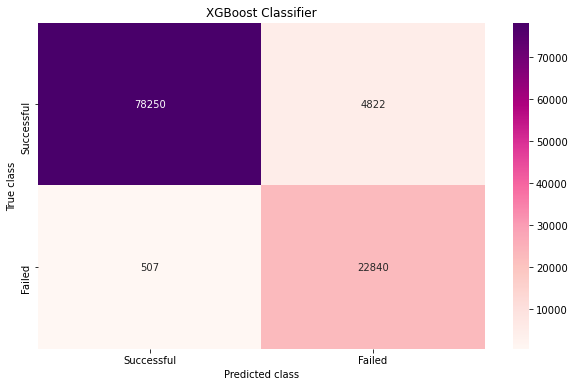

In [93]:
# XGBoost Classifier
xgb_y_pred = xgb_cl.predict(X_test)
xgb_cm = metrics.confusion_matrix(xgb_y_pred, y_test, [1,0])
sns.heatmap(xgb_cm, cmap='RdPu', annot=True, fmt='.0f', xticklabels = ['Successful', 'Failed'], yticklabels = ['Successful', 'Failed'])
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.title('XGBoost Classifier')
plt.savefig('xg_boost_classifier')

In [94]:
print('\033[1m The result is telling us that we have: ',(xgb_cm[0,0]+xgb_cm[1,1]),'correct predictions\033[1m')
print('\033[1m The result is telling us that we have: ',(xgb_cm[0,1]+xgb_cm[1,0]),'incorrect predictions\033[1m')
print('\033[1m We have a total predictions of: ',(xgb_cm.sum()))

 The result is telling us that we have:  101090 correct predictions
 The result is telling us that we have:  5329 incorrect predictions
 We have a total predictions of:  106419


In [95]:
print(classification_report(y_test, xgb_cl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     27662
           1       0.94      0.99      0.97     78757

    accuracy                           0.95    106419
   macro avg       0.96      0.91      0.93    106419
weighted avg       0.95      0.95      0.95    106419



# Feature Importance for Random Forest Model

In [96]:
feature_labels = X.columns
importance = rf.feature_importances_
feature_indexes_by_importance = importance.argsort()[::-1]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

price-69.56%
ride_distance-4.52%
user_id-4.47%
order_id-4.00%
distance-3.53%
hour-2.24%
day-1.99%
country_mx-1.33%
weekday-1.25%
month-1.17%
country_hu-1.07%
failed_attempts-0.98%
country_ee-0.94%
country_ua-0.60%
country_za-0.35%
country_ng-0.34%
country_ge-0.27%
country_rs-0.25%
country_az-0.19%
country_pl-0.19%
country_lv-0.16%
country_ke-0.14%
country_cz-0.13%
country_ro-0.10%
country_lt-0.07%
country_sk-0.06%
country_eg-0.04%
country_gh-0.03%
country_mt-0.02%
country_fi-0.01%
country_sa-0.00%
country_ca-0.00%


In [97]:
df_features = [x for i,x in enumerate(X.columns) if i!=10]

sns.set(style ='white')
plt.rcParams['figure.figsize'] = (14.0, 7.0)
def plot_feature_importances(model):
    plt.figure(figsize=(8,6))
    n_features = 10
    plt.barh(range(n_features), rf.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df_features)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.ylim(-1, n_features)
    plot_feature_importances(rf)
    plt.savefig('feature_importance')

c:\users\jacob\appdata\local\programs\python\python38\lib\site-packages\xgboost\data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


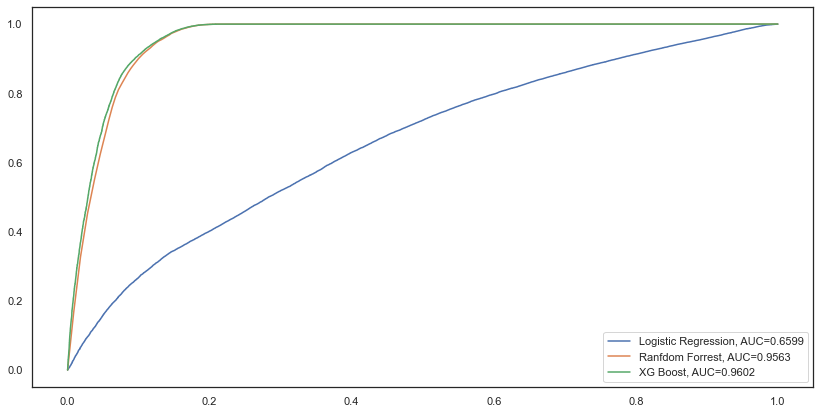

In [98]:
#set up plotting area
plt.figure(0).clf()

#fit logistic regression model and plot ROC curve
logreg.fit(X_train, y_train)
y_pred = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

#fit random forrest model and plot ROC curve
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Ranfdom Forrest, AUC="+str(auc))

#fit xgboost model and plot ROC curve
xgb_cl.fit(X_train, y_train)
y_pred = xgb_cl.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="XG Boost, AUC="+str(auc))


#add legend
plt.legend();

# Hyperparameter Tuning 

In [99]:
param_grid = { "scale_pos_weight": [1,10,2]}

In [103]:
from sklearn.model_selection import GridSearchCV

xgb_c = xgb.XGBClassifier(objective="binary:logistic")

grid_cv = GridSearchCV(xgb_c, param_grid, n_jobs=-1, cv=10, scoring="roc_auc")
grid_cv.fit(X_train, y_train)

c:\users\jacob\appdata\local\programs\python\python38\lib\site-packages\xgboost\data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None

In [104]:
from sklearn.metrics import accuracy_score
print('Grid SearchCV accuracy: {:.3f}'.format(accuracy_score(y_test, grid_cv.predict(X_test))))

Grid SearchCV accuracy: 0.950


In [102]:
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
modelCV = grid_cv
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print('10-fold cross validation average accuracy of the XGBoost classifier model: %.3f' % (results.mean()))

c:\users\jacob\appdata\local\programs\python\python38\lib\site-packages\xgboost\data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
c:\users\jacob\appdata\local\programs\python\python38\lib\site-packages\xgboost\data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
c:\users\jacob\appdata\local\programs\python\python38\lib\site-packages\xgboost\data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
c:\users\jacob\appdata\local\programs\python\python38\lib\site-packages\xgboost\data.py:173: FutureWarning: pandas.Int64Index is d

10-fold cross validation average accuracy of the XGBoost classifier model: 0.950


# Machine Learning Conclusion
### Conclusion

* Logistic Regression has the best recall score among all algorithm that we tried in this notebook
Please, note that of the three algorithms (Logistic Regression, Random Forest, and XG Boost) chosen, XG Boost is the best classifier by ROC curve which purely shows the classifier with an **AUC** score (96%)


* When a transaction was fraudulent, how often does my classifier predict that correctly? This is measured by **recall** and a quick look at these outcomes demonstrate that XG Boost and Random forest is clearly best for this criterion. Out of all the fraudulent cases, XG Boost and Random Forest correctly retrieved 78250 out of 78757 and 78201 out of 78757 for both algorithms respectively. This translates to a turnover recall of  99% (1142/1189), better than logistic regression.


* Lastly, when a classifier predicts a transaction will be fraudulent, how often is that transaction actually fraudulent? This is measured by **precision** and both XG Boost and Random Forest is about 98% precision.


### Reason for choosingXG Boost

* The boosting algorithm leverages information from weak learners and creates strong learners and it gets better per node while the bagging like a random forest creates several decision trees and does an aggregate which is why it’s a Bootstrap AGGregation (how BAGGING was derived ) technique. I could have chosen to go with that but a weak learner in the subsamples of decision trees will affect the aggregate while boosting will use the previous tree to come up with a better tree.


* Also, from experience and research, xgboost has proven to be the best at tabular data followed closely by catboost.
